In [47]:
import numpy as np
import scipy as sp
from scipy import linalg,interpolate
import matplotlib.pylab as plt

In [104]:
def createGrids(l,refinedRegion,bins=10,refRatio=2,nGhosts=0):
    iLeft,iRight=refinedRegion
    xc=np.linspace(l[0],l[1],num=bins+1)[0:bins]
    dxc=xc[1]-xc[0]
    xc+=dxc/2
    lenXf=(iRight - iLeft + 1 )*refRatio
    xf=np.linspace(xc[iLeft] -dxc/2 , xc[iRight]+dxc/2,num=lenXf + 1 )[0:lenXf]
    xf+=0.5*(xf[1]-xf[0] )
    dxf=xf[1]-xf[0]
    # add ghosts
    extendLeft=np.array([ xf[0] - (n+1)*dxf for n in range(nGhosts)] )
    extendRight=np.array([ xf[-1] + (n+1)*dxf for n in range(nGhosts)] )
    xf=np.concatenate([extendLeft,xf,extendRight])
    return xc,xf
def mergeGrids(xc,xf,refinedRegion,nGhosts=0):
    iLeft,iRight=refinedRegion
    xLeft=xc[0:iLeft]
    xRight=xc[iRight+1:]
    xf=xf[nGhosts:len(xf)-nGhosts]
    
    return np.concatenate([xLeft,xf,xRight])
    

l=[-8,8]
region=[(2*2+3)*100,(7*2-3)*100]
bins=2000
nGhosts=1
xc,xf=createGrids(l,region,bins=bins,nGhosts=nGhosts)
xm=mergeGrids(xc,xf,region,nGhosts=nGhosts)
xm

array([-7.996, -7.988, -7.98 , ...,  7.98 ,  7.988,  7.996])

In [105]:
x=np.linspace(l[0],l[1],num=10000)
y=np.exp(-x**2)
yc=np.exp(-xc**2)
dy=-2*x*np.exp(-x**2)
ddy=-2*(1-2*x**2)*np.exp(-x**2)
yf=np.exp(-xf**2)
ym=np.exp(-xm**2)

In [106]:
def polyInterpolate(n,x,y):
    A=np.zeros(shape=(n+1,n+1))
    for i in range(n+1):
        A[:,i]=x**i
    coeffs=linalg.solve(A,y)
    return np.polynomial.polynomial.Polynomial(coeffs)
def interpolate(xc,yc,rangeC, xf,n=2,refRatio=2):
    iLeft,iRight=rangeC
    ii=0
    yf=xf*0.
    for i in range(iLeft,iRight+1):
        
        if n%2 ==0:
            p=polyInterpolate(n,xc[i-n//2:i+n//2+1],yc[i-n//2:i+n//2 + 1])
            
            for j in range(refRatio):
                yf[ii+j]=p(xf[ii+j])
        else:
            slice=range(i-(n+1)//2  ,i-(n+1)//2 + n+1)
            pLeft=polyInterpolate(n,xc[slice],yc[slice])
            
            slice=range(i+(n+1)//2 - n ,i+(n+1)//2+1)
            pRight=polyInterpolate(n,xc[slice],yc[slice])
            
            
            for j in range(refRatio//2):
                pass
                yf[ii+j]=pLeft(xf[ii+j])
            for j in range(refRatio//2,refRatio):
                pass
                yf[ii+j]=pRight(xf[ii+j])
                
            
        
            
            
        ii+=refRatio
        
    return yf
        

In [118]:
def fillBoundaries(xc,yc,xf,yf,nGhosts,kind="quadratic"):
    p=sp.interpolate.interp1d(xc, yc, kind=kind)
    yf2=p(xf)
    slice=range(nGhosts,len(xf)-nGhosts)
    yf2[slice]=yf[slice]
    return xf,yf2
xfill,yfill=fillBoundaries(xc,yc,xf,yf,nGhosts,kind="quadratic")

<IPython.core.display.Javascript object>


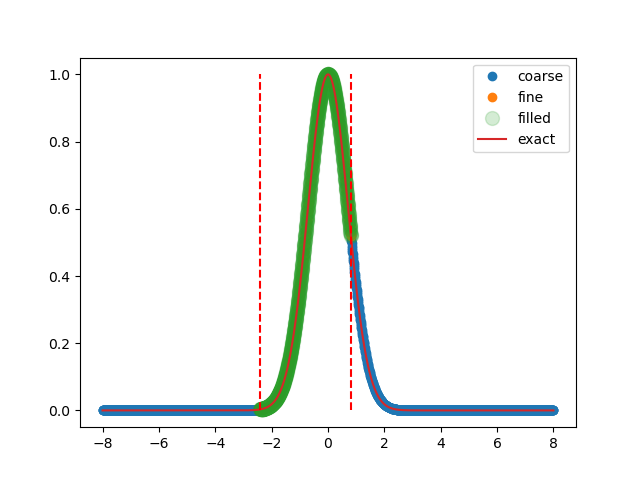

In [119]:
%matplotlib notebook
plt.plot(xc,yc,"o",label="coarse")
plt.plot(xf,yf,"o",label="fine")
#plt.plot(xm,ym,"o",label="merged",alpha=0.2,markersize=10)
plt.plot(xfill,yfill,"o",label="filled",alpha=0.2,markersize=10)

#plt.plot(xf,yfInterp1,"o",label="interp1")
#plt.plot(xf,yfInterp2,"o",label="interp2")
plt.plot(x,y,"-",label="exact")
h=np.linspace(0,1.,num=1000)
plt.plot(h*0 + xc[region[0]]-(xc[1]-xc[0])*0.5,h,"r--")
plt.plot(h*0 + xc[region[1]]+(xc[1]-xc[0])*0.5,h,"r--")


plt.legend()

In [120]:
def derivate(x,y,n=1):
    if n==1:
        dy=y*0
        dy=[(y[i+1]-y[i-1])/(x[i+1]-x[i-1]) for i in range(1,len(x)-1)]
        return x[1:len(x)-1],dy
    else:
        if n==2:
            ddy=[ 
                ( (y[i+1]-y[i])/(x[i+1]-x[i])     - (y[i]-y[i-1])/(x[i]-x[i-1]) )/(0.5*(x[i+1]-x[i-1]))
                for i in range(1,len(x)-1)]
        return x[1:len(x)-1],ddy
            

<IPython.core.display.Javascript object>


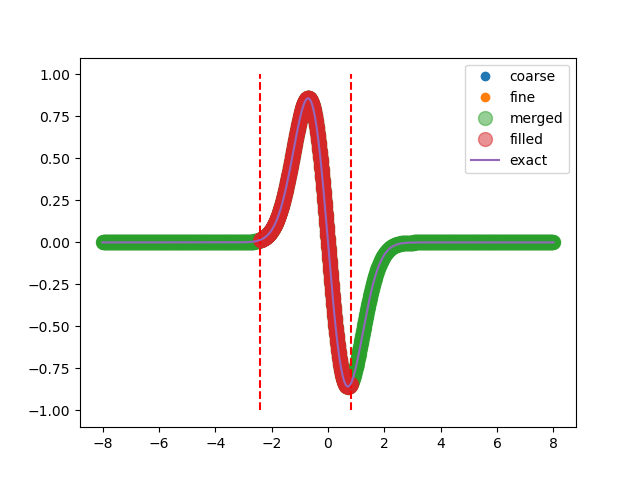

<ipython-input-121-5ff10e02cea6>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(dxm,dym,"o",label="merged",markerSize=10,alpha=0.5)
<ipython-input-121-5ff10e02cea6>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(dxfill,dyfill,"o",label="filled",markerSize=10,alpha=0.5)


In [121]:
dxc,dyc=derivate(xc,yc,n=1)
dxf,dyf=derivate(xf,yf,n=1)
dxm,dym=derivate(xm,ym,n=1)
dxfill,dyfill=derivate(xfill,yfill,n=1)


%matplotlib notebook
plt.plot(dxc,dyc,"o",label="coarse")
plt.plot(dxf,dyf,"o",label="fine")
plt.plot(dxm,dym,"o",label="merged",markerSize=10,alpha=0.5)
plt.plot(dxfill,dyfill,"o",label="filled",markerSize=10,alpha=0.5)
h=np.linspace(-1,1.,num=1000)
plt.plot(h*0 + xc[region[0]]-(xc[1]-xc[0])*0.5,h,"r--")
plt.plot(h*0 + xc[region[1]]+(xc[1]-xc[0])*0.5,h,"r--")

#plt.plot(xf,dyfInterp1,"o--",label="interp1")
#plt.plot(xf,dyfInterp2,"o--",label="interp2")

plt.plot(x,dy,"-",label="exact")

plt.legend()

<IPython.core.display.Javascript object>


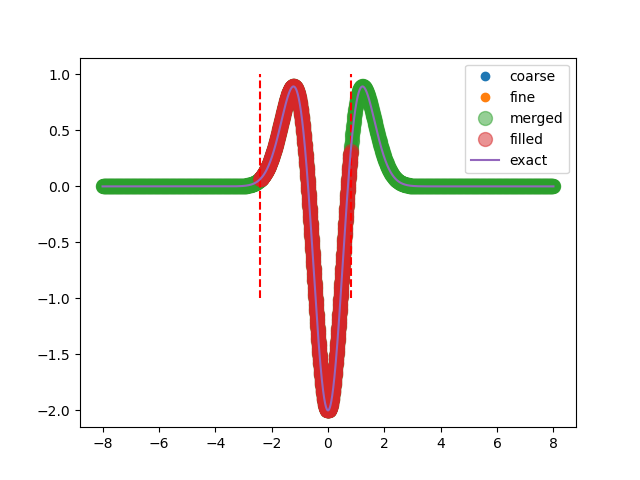

<ipython-input-123-95c21e740814>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(dxm,dym,"o",label="merged",markerSize=10,alpha=0.5)
<ipython-input-123-95c21e740814>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(dxfill,dyfill,"o",label="filled",markerSize=10,alpha=0.5)


In [123]:
dxc,dyc=derivate(xc,yc,n=2)
dxf,dyf=derivate(xf,yf,n=2)
dxm,dym=derivate(xm,ym,n=2)
dxfill,dyfill=derivate(xfill,yfill,n=2)


%matplotlib notebook
plt.plot(dxc,dyc,"o",label="coarse")
plt.plot(dxf,dyf,"o",label="fine")
plt.plot(dxm,dym,"o",label="merged",markerSize=10,alpha=0.5)
plt.plot(dxfill,dyfill,"o",label="filled",markerSize=10,alpha=0.5)
h=np.linspace(-1,1.,num=1000)
plt.plot(h*0 + xc[region[0]]-(xc[1]-xc[0])*0.5,h,"r--")
plt.plot(h*0 + xc[region[1]]+(xc[1]-xc[0])*0.5,h,"r--")

#plt.plot(xf,dyfInterp1,"o--",label="interp1")
#plt.plot(xf,dyfInterp2,"o--",label="interp2")

plt.plot(x,ddy,"-",label="exact")

plt.legend()